<a href="https://colab.research.google.com/github/hallelujahylefay/independent_component_analysis/blob/main/Independent_component_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Enable plots inside the Jupyter NotebookLet the
%matplotlib inline

In [2]:
#On se donne un probleme de séparation de sources
np.random.seed(23)
ns = np.linspace(0, 200, 1000)
# Source matrix
S = np.array([np.sin(ns * 1),
              signal.sawtooth(ns * 1.9),
              np.random.random(len(ns))]).T
# Mixing matrix
A = np.array([[0.5, 1, 0.2],
              [1, 0.5, 0.4],
              [0.5, 0.8, 1]])
# Mixed signal matrix
X = S.dot(A).T

In [22]:
X.shape

(3, 1000)

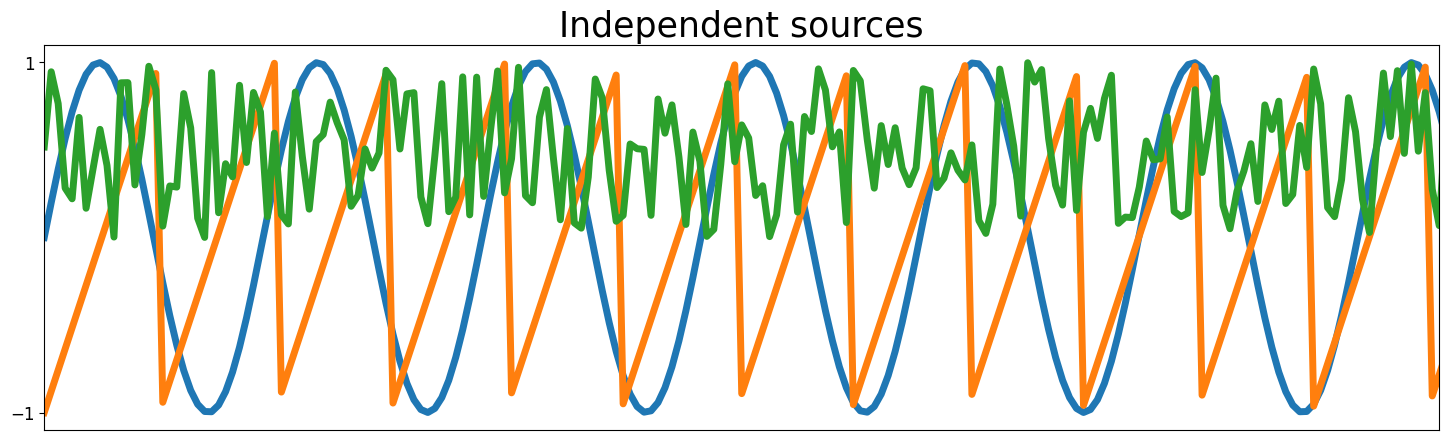

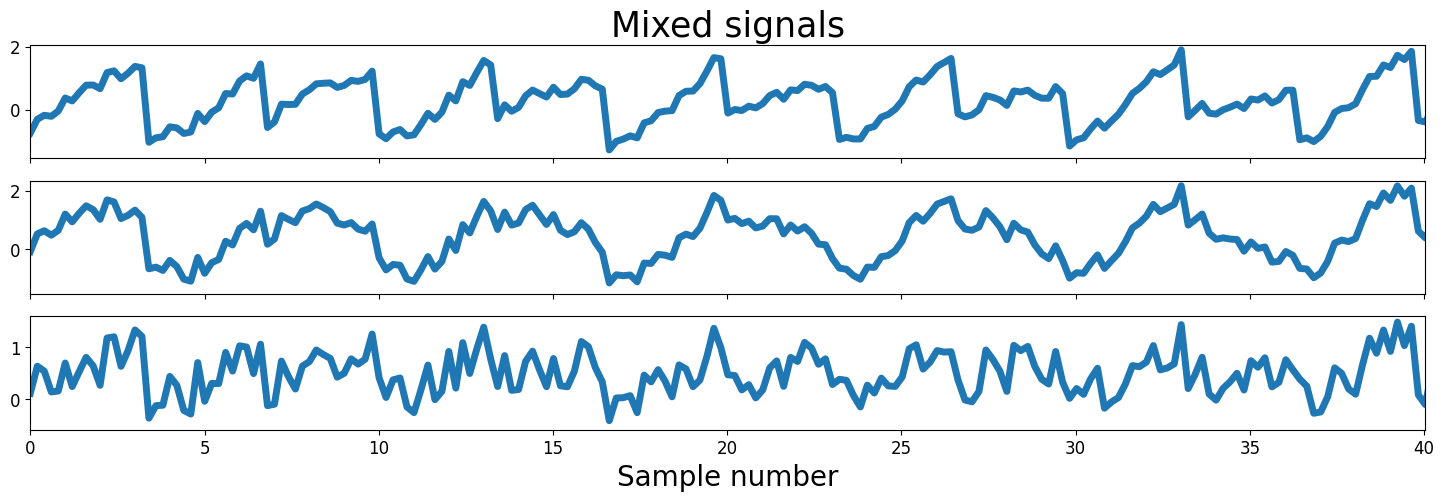

In [3]:
# Plot sources & signals
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(ns, S, lw=5)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_xlim(ns[0], ns[200])
ax.tick_params(labelsize=12)
ax.set_title('Independent sources', fontsize=25)

fig, ax = plt.subplots(3, 1, figsize=[18, 5], sharex=True)
ax[0].plot(ns, X[0], lw=5)
ax[0].set_title('Mixed signals', fontsize=25)
ax[0].tick_params(labelsize=12)

ax[1].plot(ns, X[1], lw=5)
ax[1].tick_params(labelsize=12)
ax[1].set_xlim(ns[0], ns[-1])

ax[2].plot(ns, X[2], lw=5)
ax[2].tick_params(labelsize=12)
ax[2].set_xlim(ns[0], ns[-1])
ax[2].set_xlabel('Sample number', fontsize=20)
ax[2].set_xlim(ns[0], ns[200])

plt.show()

In [4]:
# Define two non-gaussian uniform components
s1 = np.random.rand(1000)
s2 = np.random.rand(1000)
s = np.array(([s1, s2]))

# Define two gaussian components
s1n = np.random.normal(size=1000)
s2n = np.random.normal(size=1000)
sn = np.array(([s1n, s2n]))

# Define orthogonal mixing matrix
A = np.array(([0.96, -0.28],[0.28, 0.96]))

# Mix signals
mixedSignals = s.T.dot(A)
mixedSignalsN = sn.T.dot(A)

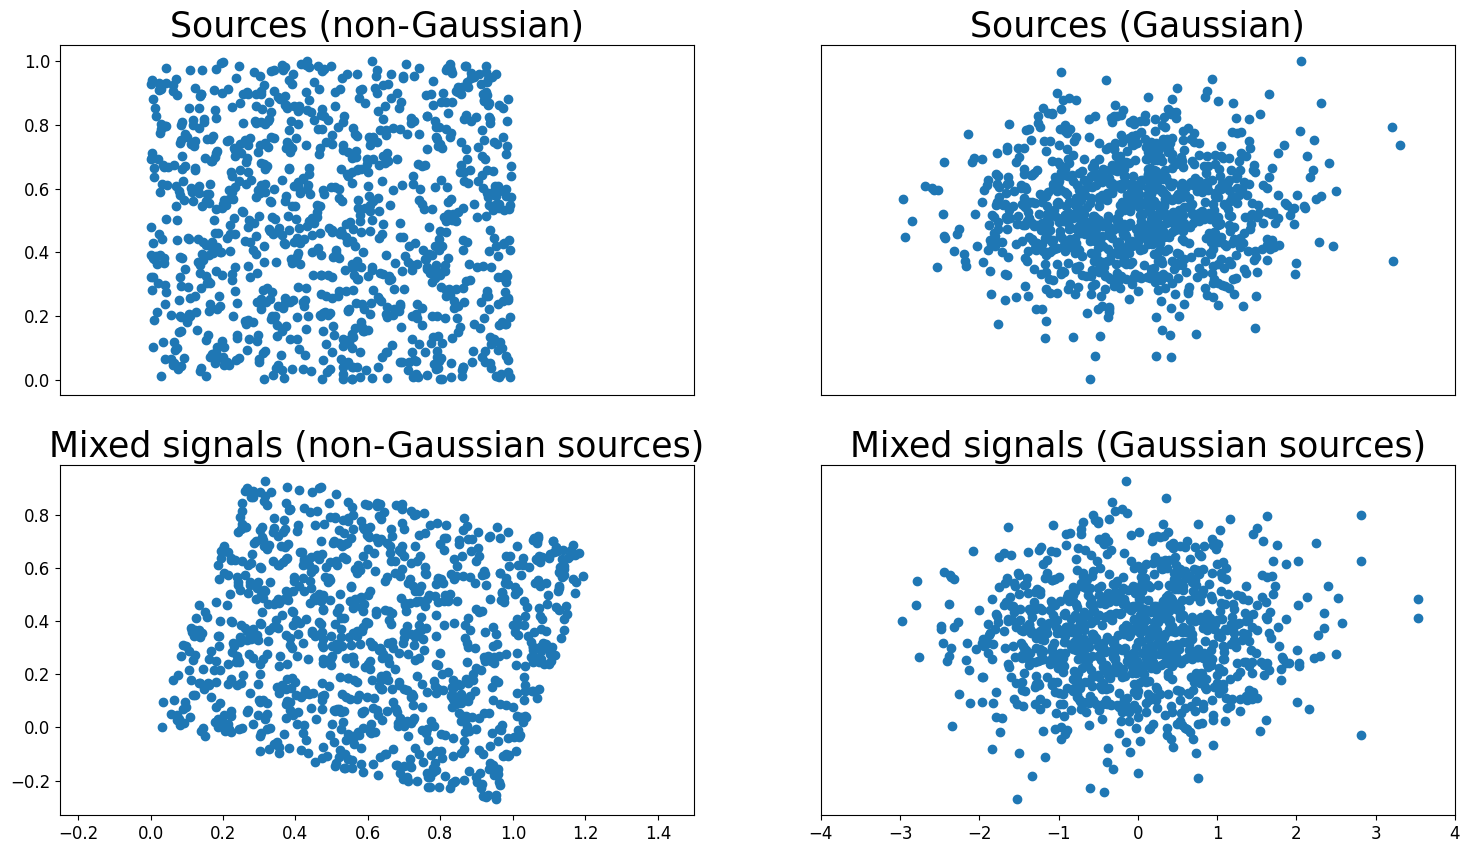

In [5]:
# Plot results
fig, ax = plt.subplots(2, 2, figsize=[18, 10])
ax[0][0].scatter(s[0], s[1])
ax[0][0].tick_params(labelsize=12)
ax[0][0].set_title('Sources (non-Gaussian)', fontsize=25)
ax[0][0].set_xlim([-0.25, 1.5])
ax[0][0].set_xticks([])

ax[0][1].scatter(sn[0], sn[1])
ax[0][1].tick_params(labelsize=12)
ax[0][1].set_title('Sources (Gaussian)', fontsize=25)
ax[0][1].set_xlim([-4, 4])
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])

ax[1][0].scatter(mixedSignals.T[0], mixedSignals.T[1])
ax[1][0].tick_params(labelsize=12)
ax[1][0].set_title('Mixed signals (non-Gaussian sources)', fontsize=25)
ax[1][0].set_xlim([-0.25, 1.5])

ax[1][1].scatter(mixedSignalsN.T[0], mixedSignalsN.T[1])
ax[1][1].tick_params(labelsize=12)
ax[1][1].set_title('Mixed signals (Gaussian sources)', fontsize=25)
ax[1][1].set_xlim([-4, 4])
ax[1][1].set_yticks([])

plt.show()

### Visualize properties of toy signals

To check if the properties discussed above also apply for our toy signals we will plot them accordingly.
As expected the source signals are distributed on a square for non-Gaussian random variables. Likewise the mixed signals form a parallelogram in the right plot of Figure 3 which shows that the mixed signals are not independent anymore.

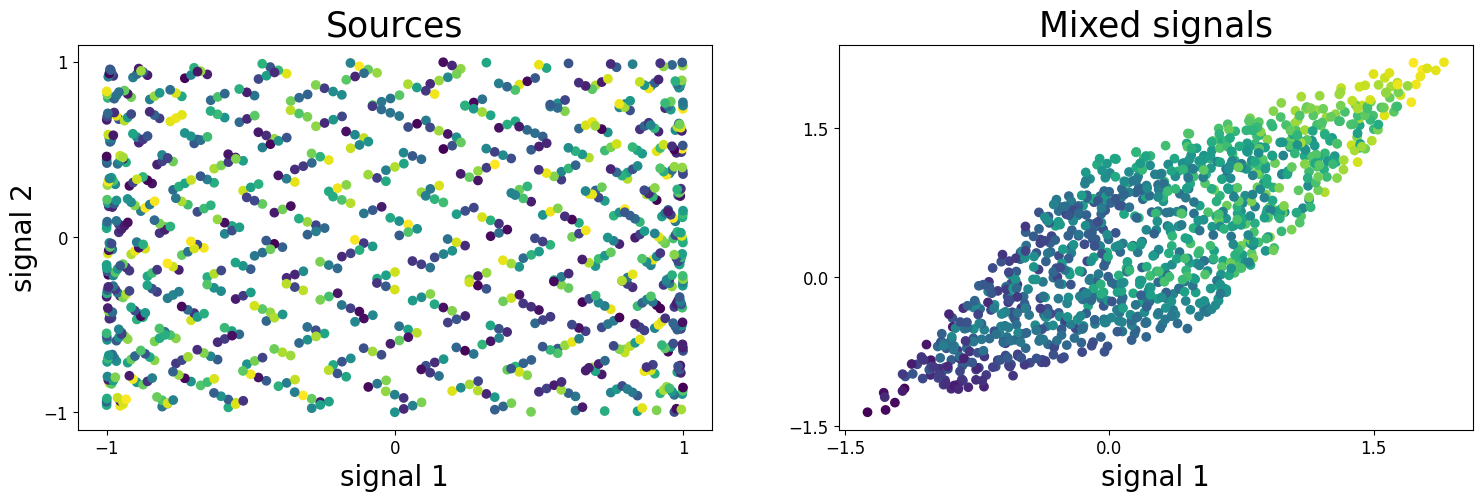

In [6]:
fig, ax = plt.subplots(1, 2, figsize=[18, 5])
ax[0].scatter(S.T[0], S.T[1], c=S.T[2])
ax[0].tick_params(labelsize=12)
ax[0].set_yticks([-1, 0, 1])
ax[0].set_xticks([-1, 0, 1])
ax[0].set_xlabel('signal 1', fontsize=20)
ax[0].set_ylabel('signal 2', fontsize=20)
ax[0].set_title('Sources', fontsize=25)

ax[1].scatter(X[0], X[1], c=X[2])
ax[1].tick_params(labelsize=12)
ax[1].set_yticks([-1.5, 0, 1.5])
ax[1].set_xticks([-1.5, 0, 1.5])
ax[1].set_xlabel('signal 1', fontsize=20)
ax[1].set_title('Mixed signals', fontsize=25)
plt.show()

## Preprocessing functions


In [7]:
def center(x):
    mean = np.mean(x, axis=1, keepdims=True)
    centered =  x - mean
    return centered, mean

In [8]:
def covariance(x):
    mean = np.mean(x, axis=1, keepdims=True)
    n = np.shape(x)[1] - 1
    m = x - mean

    return (m.dot(m.T))/n

In [9]:
def whiten(x):
    # Calculate the covariance matrix
    coVarM = covariance(X)

    # Single value decoposition
    U, S, V = np.linalg.svd(coVarM)

    # Calculate diagonal matrix of eigenvalues
    d = np.diag(1.0 / np.sqrt(S))

    # Calculate whitening matrix
    whiteM = np.dot(U, np.dot(d, U.T))

    # Project onto whitening matrix
    Xw = np.dot(whiteM, X)

    return Xw, whiteM

## 1. Fast ICA algorithm as an approx negentropy maximisation problem

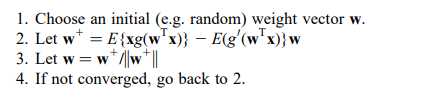


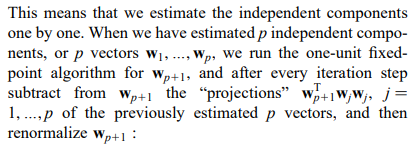

In [11]:
def fastIca(signals,  alpha = 1, thresh=1e-8, iterations=5000):
    m, n = signals.shape

    # Initialize random weights
    W = np.random.rand(m, m)

    for c in range(m):
            w = W[c, :].copy().reshape(m, 1)
            w = w / np.sqrt((w ** 2).sum())

            i = 0
            while (i < iterations):

                # Dot product of weight and signal
                wTx = np.dot(w.T, signals)

                # Pass w*s into contrast function g
                gwTx = np.tanh(wTx * alpha).T

                # Pass w*s into g prime
                g_wTx = (1 - np.square(np.tanh(wTx))) * alpha

                # Update weights
                w_ = (signals * gwTx.T).mean(axis=1) - g_wTx.mean() * w.squeeze()

                # Decorrelate weights
                w_ = w_ - np.dot(np.dot(w_, W[:c].T), W[:c])

                # Normalize
                w_ = w_ / np.sqrt((w_ ** 2).sum())

                # Calculate limit condition
                w_ /= np.linalg.norm(w_)

                if np.abs(np.abs((w_ * w).sum()) - 1) < thresh:
                  break

                # Update weights
                w = w_

                # Update counter
                i += 1

            W[c, :] = w.T
    return W

### Pre-processing

So... before we run the ICA we need to do the pre-processing.

In [12]:
# Center signals
Xc, meanX = center(X)

# Whiten mixed signals
Xw, whiteM = whiten(Xc)

### Check whitening

In [13]:
# Check if covariance of whitened matrix equals identity matrix
print(np.round(covariance(Xw)))

[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]


### Running the ICA

In [16]:
W = fastIca(Xw,  alpha=1)

#Un-mix signals using
unMixed = np.dot(W, Xw)

# Subtract mean
unMixed = (unMixed - meanX).T

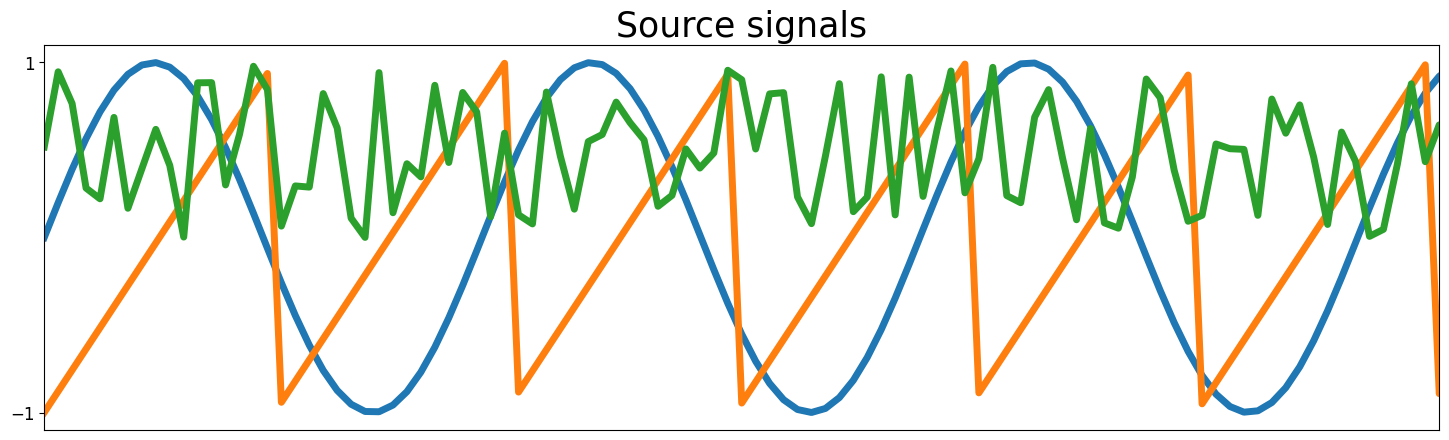

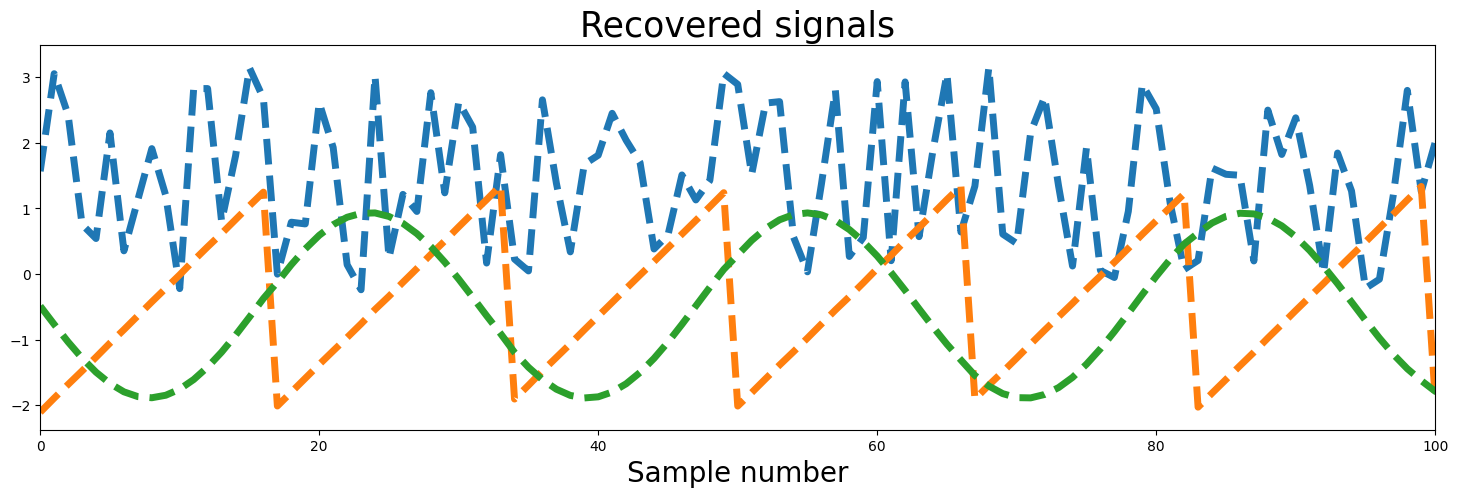

In [17]:
# Plot input signals (not mixed)
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(S, lw=5)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Source signals', fontsize=25)
ax.set_xlim(0, 100)

fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(unMixed, '--', label='Recovered signals', lw=5)
ax.set_xlabel('Sample number', fontsize=20)
ax.set_title('Recovered signals', fontsize=25)
ax.set_xlim(0, 100)

plt.show()

The result of the ICA are plotted above, and the result looks very good. We got all three sources back!

## Kurtosis

So finally lets check one last thing: The kurtosis of the signals.

In [37]:
# Calculate Kurtosis

def kurt(x):
    n = np.shape(x)[0]
    x=(x-np.mean(x))/np.std(x)
    kurt = np.mean((x**4)) - 3

    return kurt

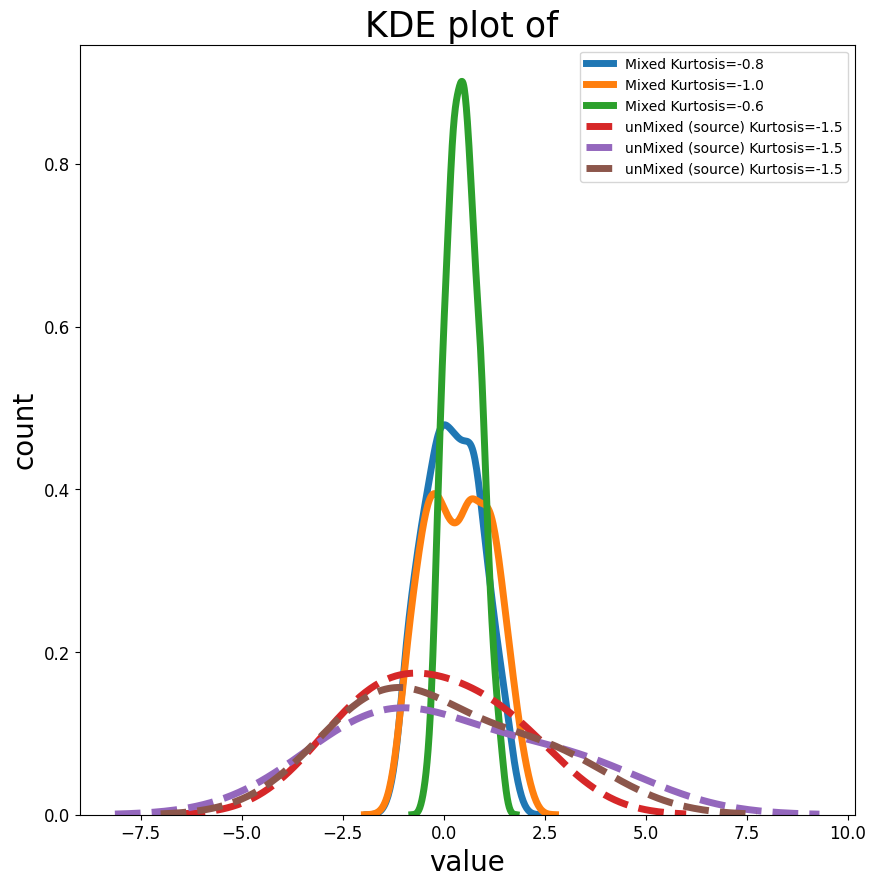

In [43]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i in range(X.shape[0]):

    sns.kdeplot(X[i, :], lw=5, label='Mixed Kurtosis={}'.format(np.round(kurt(X[i, :]), decimals=1)))

for i in range(X.shape[0]):
    sns.kdeplot(unMixed[i, :], lw=5, ls='--', label='unMixed (source) Kurtosis={}'.format(np.around(kurt(unMixed[i, :]), decimals=1)))

ax.tick_params(labelsize=12)
ax.legend()

ax.set_xlabel('value', fontsize=20)
ax.set_ylabel('count', fontsize=20)
ax.set_title('KDE plot of ', fontsize=25)
plt.show()

# 2. Fast ICA as a MLE problem


Hyvarinen, A. (1999b). The fixed-point algorithm and maximum likelihood
estimation for independent component analysis. Neural Processing
Letters, 10 (1), 1–5.

In [47]:
def fastICA_MLE(X, beta, max_iter=1000, tol=1e-5):

    n_features = X.shape[1]
    V = np.eye(n_features)  # Initialize V as the identity matrix

    for i in range(max_iter):
        V_old = V.copy()
        y = V @ X.T  # y = Vx
        g_y = np.tanh(y)  # Apply the function g to y
        D = np.diag(1.0 / (beta + np.mean(g_y * y, axis=1)))  # D is the inverse of diag(beta_i + E{g'(y_i)})

        # Update rule for V
        V += D @ (np.diag(-beta) + np.mean(g_y[None, :] * y[:, None, :], axis=2)) @ V

        # Check for convergence
        if np.linalg.norm(V - V_old) < tol:
            break

    return V


### Running the ICA

In [46]:
# Center signals
Xc, meanX = center(X)

# Whiten mixed signals
Xw, whiteM = whiten(Xc)

In [50]:
beta = np.random.rand(3)
W = fastICA_MLE(Xw,beta)

#Un-mix signals using
unMixed = np.dot(W, Xw)

# Subtract mean
unMixed = (unMixed - meanX).T

ValueError: ignored

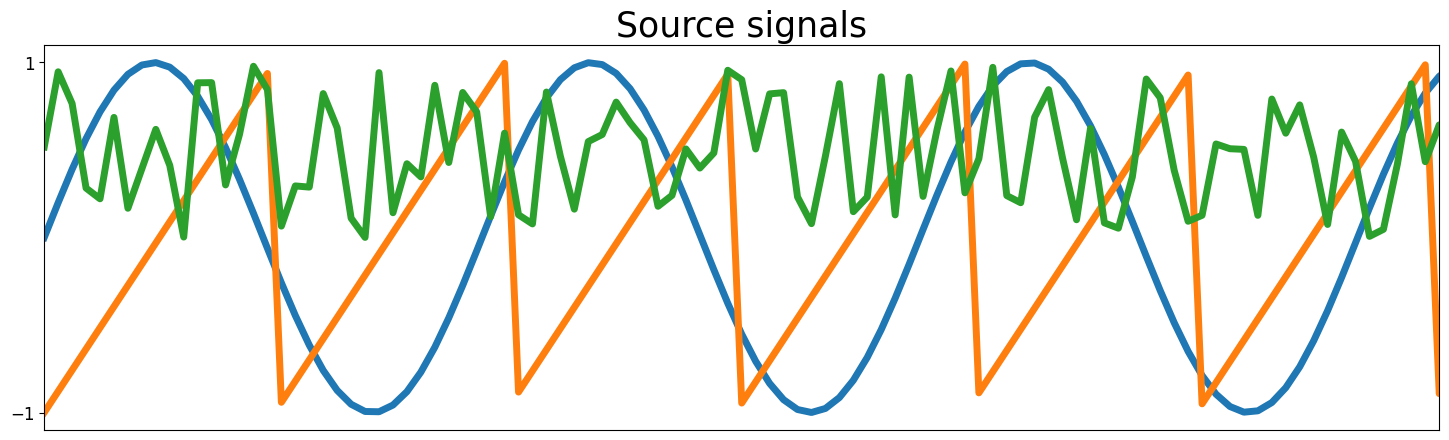

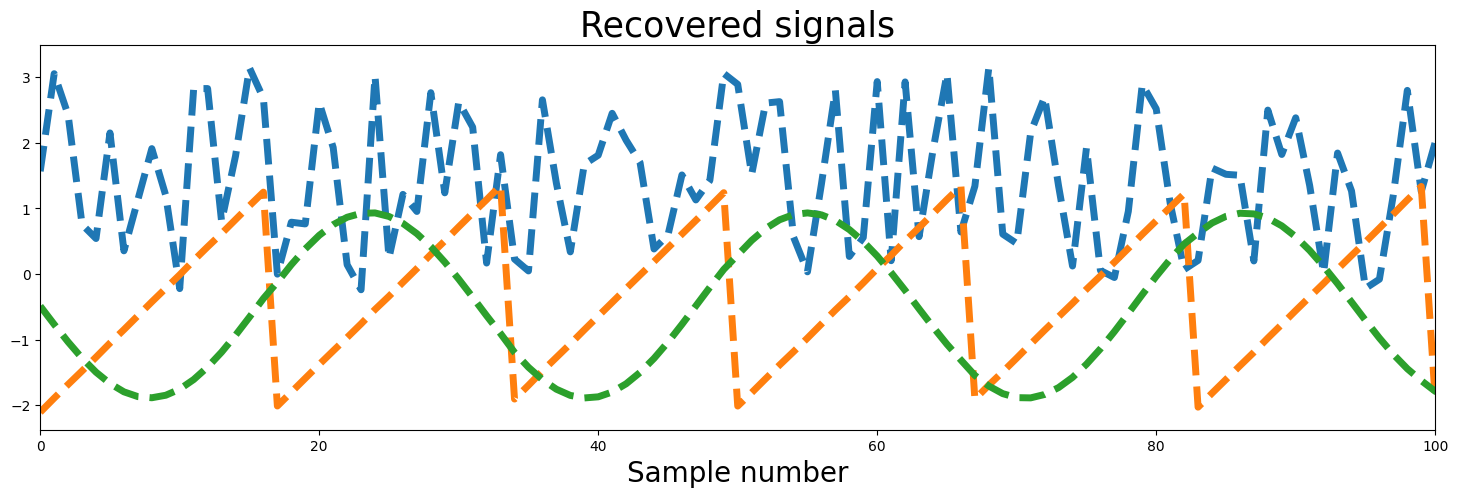

In [ ]:
# Plot input signals (not mixed)
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(S, lw=5)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Source signals', fontsize=25)
ax.set_xlim(0, 100)

fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(unMixed, '--', label='Recovered signals', lw=5)
ax.set_xlabel('Sample number', fontsize=20)
ax.set_title('Recovered signals', fontsize=25)
ax.set_xlim(0, 100)

plt.show()

The result of the ICA are plotted above, and the result looks very good. We got all three sources back!

In [ ]:
# import numpy as np

# def FastICA_several_units(X, n_components, fun='logcosh', max_iter=200, tol=1e-04):
#     """
#     Perform FastICA for several units.

#     Parameters:
#     X: ndarray, shape (n_features, n_samples)
#         The data matrix with features as rows and samples as columns.
#     n_components: int
#         The number of components to extract.
#     fun: str, optional
#         The functional form of the G function used in the approximation to negentropy.
#         Possible values are 'logcosh', 'exp', and 'cube'.
#     max_iter: int, optional
#         Maximum number of iterations during fit.
#     tol: float, optional
#         Tolerance on update at each iteration.

#     Returns:
#     S: ndarray, shape (n_components, n_samples)
#         The estimated independent components.
#     W: ndarray, shape (n_components, n_features)
#         The unmixing matrix.
#     """

#     # Preprocessing: centering and whitening
#     X = X - X.mean(axis=1, keepdims=True)
#     cov = np.cov(X)
#     d, E = np.linalg.eigh(cov)
#     D = np.diag(1. / np.sqrt(d))
#     X_white = np.dot(E, np.dot(D, np.dot(E.T, X)))

#     # Initialize W
#     np.random.seed(0)
#     W = np.zeros((n_components, X.shape[0]))
#     for i in range(n_components):
#         w = np.random.normal(size=(X.shape[0],))

#         for j in range(max_iter):
#             w_old = w.copy()

#             if fun == 'logcosh':
#                 gwtx = np.tanh(np.dot(w.T, X_white))
#                 g_wtx = 1 - gwtx**2
#             elif fun == 'exp':
#                 gwtx = np.exp(-(np.dot(w.T, X_white)**2) / 2)
#                 g_wtx = -np.dot(w.T, X_white) * gwtx
#             elif fun == 'cube':
#                 gwtx = np.dot(w.T, X_white)**3
#                 g_wtx = 3 * np.dot(w.T, X_white)**2

#             w = (X_white * gwtx).mean(axis=1) - g_wtx.mean() * w

#             # Decorrelate w from the previously estimated components
#             w -= np.dot(np.dot(W[:i, :].T, w), W[:i, :])
#             w /= np.linalg.norm(w)

#             if np.abs(np.abs((w * w_old).sum()) - 1) < tol:
#                 break

#         W[i, :] = w

#     S = np.dot(W, X_white)

#     return S, W

# # Example usage
# # X is a matrix with n_features rows and n_samples columns
# # For example, X could be a 2x1000 matrix (2 features, 1000 samples)
# # n_components is the number of independent components to extract, e.g., 2

# # Example data (to be replaced with actual data)
# n_features = 2
# n_samples = 1000
# n_components = 2
# X = np.random.rand(n_features, n_samples)

# # Running the FastICA algorithm for several units
# S, W = FastICA_several_units(X, n_components)

# S, W
